In [8]:
import torch as th
import numpy as np
from append_directories import *
from functools import partial
import generate_true_unconditional_samples
import matplotlib.pyplot as plt

home_folder = append_directory(6)
sde_folder = home_folder + "/brown_resnick/sde_diffusion/masked/unparameterized"
#sde configs folder
sde_configs_vp_folder = sde_folder + "/configs/vp"
sys.path.append(sde_configs_vp_folder)
import ncsnpp_config
sys.path.append(sde_folder)
from models import ncsnpp
import sde_lib

n = 32
T = 1000
device = "cuda:0"



#get trained score model
config = ncsnpp_config.get_config()
config.model.num_scales = 1000
config.model.beta_max = 20

score_model = th.nn.DataParallel((ncsnpp.NCSNpp(config)).to("cuda:0"))
score_model.load_state_dict(th.load((sde_folder + "/trained_score_models/vpsde/model4_beta_min_max_01_20_1000_1.6_1.6_random050_masks.pth")))
score_model.eval()
sdevp = sde_lib.VPSDE(beta_min=0.1, beta_max=20, N=1000)


def log_transformation(images):

    images = np.log(np.where(images != 0, images, np.min(images[images != 0])))
    return images

#y is observed part of field
def p_mean_and_variance_from_score_via_mask(vpsde, score_model, device, masked_xt, mask, y, t):

    num_samples = masked_xt.shape[0]
    timestep = ((th.tensor([t])).repeat(num_samples)).to(device)
    with th.no_grad():
        score = score_model(masked_xt, timestep)
    unmasked_p_mean = (1/th.sqrt(th.tensor(vpsde.alphas[t])))*(masked_xt + th.square(th.tensor(vpsde.sigmas[t]))*score)
    masked_p_mean = th.mul((1-mask), unmasked_p_mean) + th.mul(mask, y)
    print("masked p mean masked part", th.max(th.abs(th.mul(mask, y))))
    print("unmasked p mean", th.max(th.abs(th.mul((1-mask), unmasked_p_mean))))
    unmasked_p_variance = (th.square(th.tensor(vpsde.sigmas[t])))*th.ones_like(masked_xt)
    masked_p_variance = th.mul((1-mask), unmasked_p_variance)
    return masked_p_mean, masked_p_variance

def sample_with_p_mean_variance_via_mask(vpsde, score_model, device, masked_xt, mask, y, t, num_samples):

    p_mean, p_variance = p_mean_and_variance_from_score_via_mask(vpsde, score_model, device, masked_xt, mask, y, t)
    std = th.exp(0.5 * th.log(p_variance))
    noise = th.randn_like(masked_xt)
    #just to make sure that the masked values aren't perturbed by the noise, the variance should already be masked though
    masked_noise = th.mul((1-mask), noise)
    sample = p_mean + std*masked_noise
    return sample


def posterior_sample_with_p_mean_variance_via_mask(vpsde, score_model, device, mask,
                                                   y, n, num_samples):

    unmasked_xT = th.randn((num_samples, 1, n, n)).to(device)
    masked_xT = th.mul((1-mask), unmasked_xT) + th.mul(mask, y)
    masked_xt = masked_xT
    for t in range((vpsde.N-1), 0, -1):
        print(t)
        masked_xt = sample_with_p_mean_variance_via_mask(vpsde, score_model, device, masked_xt,
                                                         mask, y, t, num_samples)

    return masked_xt

/home/julia/Dropbox/diffusion/twisted_diffusion/brown_resnick/sde_diffusion/masked/unparameterized/models/ncsnpp.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('sigmas', torch.tensor(get_sigmas(config)))


In [13]:
num_samples = 1
sdevp = sde_lib.VPSDE(beta_min=0.1, beta_max=20, N=1000)
range_value = 1.6
smooth_value = 1.6
seed_value = 43235
ref_img = generate_true_unconditional_samples.generate_brown_resnick_process(range_value, smooth_value,
                                                                             seed_value, 2,
                                                                             n)
p = .5
ref_img = ((th.from_numpy(ref_img.reshape((2,1,n,n))))[0,:,:,:]).to(device)
mask = th.bernoulli(p*th.ones((1, 1, n, n))).to(device)
y = (th.from_numpy(log_transformation((th.mul(mask, ref_img).float()).cpu().numpy()))).float().to(device)

In [22]:
def plot_spatial_field(image, max_value, min_value):

    fig, ax = plt.subplots(1)
    plt.imshow(image, vmin = min_value, vmax = max_value)
    plt.show()

def plot_masked_spatial_field(image, mask, max_value, min_value):

    fig, ax = plt.subplots(1)
    plt.imshow(image, vmin = min_value, vmax = max_value, alpha = mask)
    plt.show()

In [ ]:
sample = posterior_sample_with_p_mean_variance_via_mask(sdevp, score_model, device, mask,
                                               y, n, num_samples)

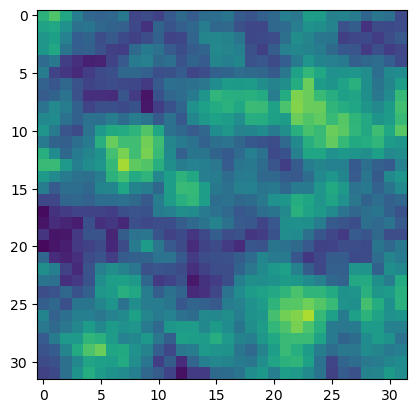

In [21]:
plot_spatial_field(log_transformation(ref_img.detach().cpu().numpy().reshape((n,n))), 4, -2)

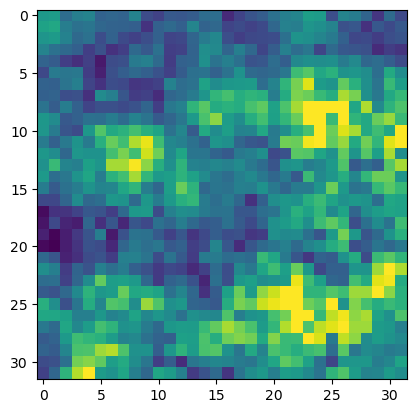

In [19]:
plot_spatial_field(sample.detach().cpu().numpy().reshape((n,n)), 4, -2)

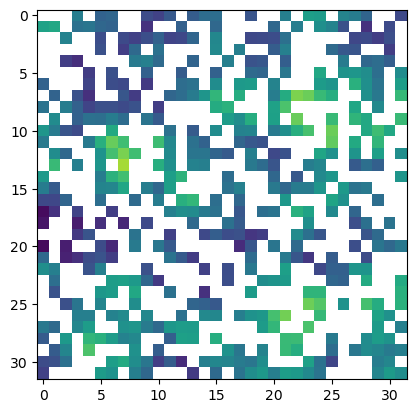

In [25]:
plot_masked_spatial_field(sample.detach().cpu().numpy().reshape((n,n)), mask.float().detach().cpu().numpy().reshape((n,n)),
                          4, -2)

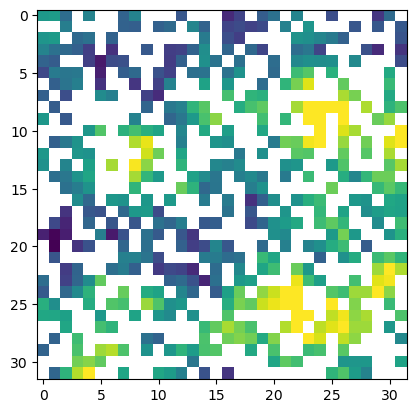

In [26]:
plot_masked_spatial_field(sample.detach().cpu().numpy().reshape((n,n)), (1-mask).float().detach().cpu().numpy().reshape((n,n)),
                          4, -2)

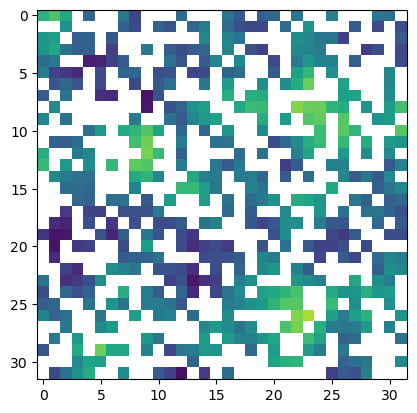

In [28]:
plot_masked_spatial_field(log_transformation(ref_img.detach().cpu().numpy().reshape((n,n))), (1-mask).float().detach().cpu().numpy().reshape((n,n)),
                          4, -2)

In [32]:
np.min(log_transformation(ref_img.detach().cpu().numpy()))

-1.8456635454466548

In [33]:
th.min(sample)

tensor(-1.9976, device='cuda:0')

In [34]:
th.max(sample)

tensor(5.5929, device='cuda:0')

In [35]:
np.max(log_transformation(ref_img.detach().cpu().numpy()))

3.2615589160945633

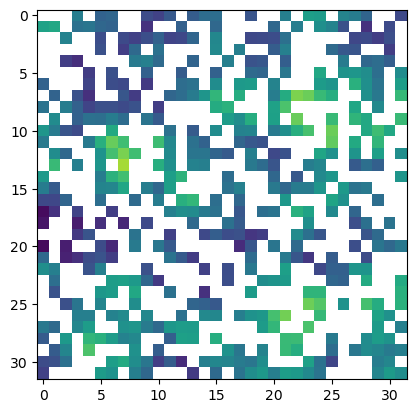

In [24]:
plot_masked_spatial_field(log_transformation(ref_img.detach().cpu().numpy().reshape((n,n))),
                          mask.float().detach().cpu().numpy().reshape((n,n)), 4, -2)